In [1]:
import numpy as np  
import matplotlib.pylab as plt
import pickle
from sklearn.decomposition import PCA
import gpflow




# import SetPub
# SetPub.set_pub()

In [2]:
def scale01(fmin, fmax, f):
    return (f - fmin) / (fmax - fmin)


def modelLoad(nRankMax, snap_ID):
    GPmodel = modelDir + 'nCorrLogfixedGP_smooth_rank' + str(nRankMax) + 'snap' + str(snap_ID)  
    PCAmodel = modelDir + 'nCorrLogfixedPCA_smooth_rank' + str(nRankMax) + 'snap' + str(snap_ID)  

    ctx_for_loading = gpflow.saver.SaverContext(autocompile=False)
    saver = gpflow.saver.Saver()
    GPm = saver.load(GPmodel, context=ctx_for_loading)
    GPm.clear()
    GPm.compile()
    PCAm = pickle.load(open(PCAmodel, 'rb'))

    print(GPmodel)
    return GPm, PCAm

def GPy_predict(gpmodel, para_array):
    m1p = gpmodel.predict_f(para_array)  # [0] is the mean and [1] the predictive
    W_predArray = m1p[0]
    W_varArray = m1p[1]
    return W_predArray, W_varArray


def Emu(gpmodel, pcamodel, para_array):
    para_array = np.array(para_array)
    para_array[3] = np.log10(para_array[3])
    print(para_array)
    para_array_rescaled = scale01(lhdmin, lhdmax, para_array)
    if len(para_array.shape) == 1:
        print(para_array_rescaled)
        W_predArray, _ = GPy_predict(gpmodel, np.expand_dims(para_array_rescaled, axis=0))
        x_decoded = pcamodel.inverse_transform(W_predArray)
        return np.squeeze(x_decoded)#[0]

def MGemu(Om, ns, s8, fR0, n, z):
    if (z==0):
        GPm, PCAm = modelLoad(nRankMax, 99)
        Pk_interp = Emu(GPm, PCAm, [Om, ns, s8, fR0, n])

    else:
        snap_idx_nearest = (np.abs(z_all - z)).argmin()
        if (z > z_all[snap_idx_nearest]): 
            snap_ID_z1 = snap_idx_nearest - 1    
        else:
            snap_ID_z1 = snap_idx_nearest 
        snap_ID_z2 = snap_ID_z1 + 1

        GPm1, PCAm1 = modelLoad(nRankMax, snap_ID_z1)
        Pk_z1 = Emu(GPm1, PCAm1, [Om, ns, s8, fR0, n])
        z1 = z_all[snap_ID_z1]

        GPm2, PCAm2 = modelLoad(nRankMax, snap_ID_z2)
        Pk_z2 = Emu(GPm2, PCAm2, [Om, ns, s8, fR0, n])
        z2 = z_all[snap_ID_z2]
        
        # print('Linear interpolating for redshift between', 'z1= '+ str(z_all[snap_ID_z1]), 'z2= '+ str(z_all[snap_ID_z2]))
        # print('Linear interpolating for snapshots ', 'for z1= '+ str(snap_ID_z1), 'and z2= '+ str(snap_ID_z2))
        
        Pk_interp = np.zeros_like(Pk_z1)
        Pk_interp = Pk_z2 + (Pk_z1 - Pk_z2)*(z - z2)/(z1 - z2)
    return Pk_interp


In [3]:
# nRankMax = 16
# # del_idx = [5, 25, 4, 42]  ## Random holdouts (not used in training, reserved for validation) 


# dataDir = "./Data/Emulator213bins/" ## Data folder
# modelDir = "./Models/" ## Data folder

# az = np.loadtxt(dataDir + 'timestepsCOLA.txt', skiprows=1) 
# fileIn = dataDir + 'ratiosbins_' + str(99) + '.txt'

# loadFile = np.loadtxt(fileIn)
# PmPl_all = loadFile[:, 1:].T
# kvals = loadFile[:,0]
# z_all = az[:, 1]

# lhdmin, lhdmax = np.loadtxt(dataDir + 'paralims.txt')

In [25]:
nRankMax = 16
snap_ID = 61
del_idx = [5, 25, 4, 42]  ## Random holdouts (not used in training, reserved for validation) 


dataDir = "./Data/Fixedn/" ## Data folder
modelDir = "./Models/Fixedn/" ## Data folder
plotsDir = "./Plots/Fixedn/" ## Data folder

az = np.loadtxt(dataDir + 'timestepsCOLA.txt', skiprows=1) 
fileIn = dataDir + 'ratiosbinsnew_' + str(99) + '.txt'

loadFile = np.loadtxt(fileIn)
PmPl_all = loadFile[:, 1:].T
kvals = loadFile[:,0]
z_all = az[:, 1]

lhdmin, lhdmax = np.loadtxt(dataDir + 'paralims_nCorr.txt')

In [40]:
nbody_1 = np.loadtxt('./Data/Nbody_validation/ratios_19.txt')
nbody_2 = np.loadtxt('./Data/Nbody_validation/ratios_22.txt')
nbody_3 = np.loadtxt('./Data/Nbody_validation/ratios_27.txt')
nbody_4 = np.loadtxt('./Data/Nbody_validation/ratios_29.txt')
nbody_5 = np.loadtxt('./Data/Nbody_validation/ratios_33.txt')
nbody_6 = np.loadtxt('./Data/Nbody_validation/ratios_35.txt')
nbody_7 = np.loadtxt('./Data/Nbody_validation/ratios_36.txt')
nbody_8 = np.loadtxt('./Data/Nbody_validation/ratios_38.txt')

nbody_pk = np.array([nbody_1, nbody_2, nbody_3, nbody_4, nbody_5, nbody_6, nbody_7, nbody_8])


In [53]:
cola_val_dir = './Data/Nbody_validation/COLApks/'
sim_id = ['F4', 'F5', 'F6', 'LCDM']
z_array = [1.0165, 0.8069, 0.50557, 0.3984, 0.200981514826109, 0.10923, 0.06495, 0.0]


# for i in [0, 1, 2, 3, 4, 5, 6, 7]:

def cola_pk(snapID):

    if snapID==4: 
        F4_cola = 0
        F5_cola = 0
        F6_cola = 0

    else: 
        cola_f4 = np.loadtxt(cola_val_dir + 'P' + sim_id[0] + 'wmap_z' + str(z_array[snapID]) + '.txt')
        cola_f5 = np.loadtxt(cola_val_dir + 'P' + sim_id[1] + 'wmap_z' + str(z_array[snapID]) + '.txt')
        cola_f6 = np.loadtxt(cola_val_dir + 'P' + sim_id[2] + 'wmap_z' + str(z_array[snapID]) + '.txt')
        cola_lcdm = np.loadtxt(cola_val_dir + 'P' + sim_id[3] + 'wmap_z' + str(z_array[snapID]) + '.txt')

        F4_cola = np.array([ cola_f4[:, 0], cola_f4[:, 1]/cola_lcdm[:, 1] ])
        F5_cola = np.array([ cola_f5[:, 0], cola_f5[:, 1]/cola_lcdm[:, 1] ])
        F6_cola = np.array([ cola_f6[:, 0], cola_f6[:, 1]/cola_lcdm[:, 1] ])

    return F4_cola, F5_cola, F6_cola



f4, f5, f6 = cola_pk(0)

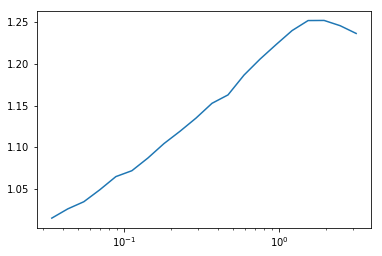

In [57]:
plt.plot(f4[0], f4[1])
plt.xscale('log')

In [42]:
h = 0.697
Om_f=(h**2)*0.281
ns_f=0.971
s8_f=0.82
n_f=1

fr0_f4 = 1e-4
fr0_f5 = 1e-5
fr0_f6 = 1e-6

z_array = [1.016539373193011, 0.806909104243328, 0.505668030951772, 0.398366114391517, 0.200981514826109, 0.109319263502801, 0.064946498060623, 0.0]

In [43]:
snap_id_array = [0, 2, 7] #range(8) 


./Models/Fixedn/nCorrLogfixedGP_smooth_rank16snap47
[ 0.13651233  0.971       0.82       -4.          1.        ]
[0.47178083 0.605      0.6        1.         0.25      ]
./Models/Fixedn/nCorrLogfixedGP_smooth_rank16snap48
[ 0.13651233  0.971       0.82       -4.          1.        ]
[0.47178083 0.605      0.6        1.         0.25      ]
Linear interpolating for snapshots  for z1= 47 and z2= 48
./Models/Fixedn/nCorrLogfixedGP_smooth_rank16snap64
[ 0.13651233  0.971       0.82       -4.          1.        ]
[0.47178083 0.605      0.6        1.         0.25      ]
./Models/Fixedn/nCorrLogfixedGP_smooth_rank16snap65
[ 0.13651233  0.971       0.82       -4.          1.        ]
[0.47178083 0.605      0.6        1.         0.25      ]
Linear interpolating for snapshots  for z1= 64 and z2= 65
./Models/Fixedn/nCorrLogfixedGP_smooth_rank16snap99
[ 0.13651233  0.971       0.82       -4.          1.        ]
[0.47178083 0.605      0.6        1.         0.25      ]


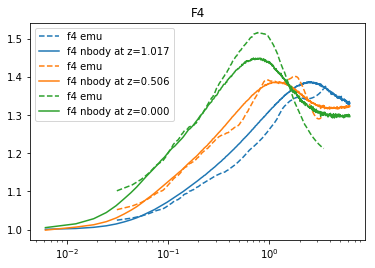

In [44]:
plt.figure(1)
for snap_id in snap_id_array:
    emu = MGemu(Om=Om_f, ns=ns_f, s8=s8_f, fR0=fr0_f4, n=n_f, z=z_array[snap_id])
    plt.plot(kvals, emu, '--', label='f4 emu')
    plt.plot(nbody_pk[snap_id, :,0], nbody_pk[snap_id, :, 1], label='f4 nbody at z=%0.3f'%z_array[snap_id], color=plt.gca().lines[-1].get_color())
plt.xscale('log')
plt.title('F4')
plt.legend()
plt.show()

./Models/Fixedn/nCorrLogfixedGP_smooth_rank16snap47
[ 0.13651233  0.971       0.82       -5.          1.        ]
[0.47178083 0.605      0.6        0.75       0.25      ]
./Models/Fixedn/nCorrLogfixedGP_smooth_rank16snap48
[ 0.13651233  0.971       0.82       -5.          1.        ]
[0.47178083 0.605      0.6        0.75       0.25      ]
Linear interpolating for snapshots  for z1= 47 and z2= 48
./Models/Fixedn/nCorrLogfixedGP_smooth_rank16snap64
[ 0.13651233  0.971       0.82       -5.          1.        ]
[0.47178083 0.605      0.6        0.75       0.25      ]
./Models/Fixedn/nCorrLogfixedGP_smooth_rank16snap65
[ 0.13651233  0.971       0.82       -5.          1.        ]
[0.47178083 0.605      0.6        0.75       0.25      ]
Linear interpolating for snapshots  for z1= 64 and z2= 65
./Models/Fixedn/nCorrLogfixedGP_smooth_rank16snap99
[ 0.13651233  0.971       0.82       -5.          1.        ]
[0.47178083 0.605      0.6        0.75       0.25      ]


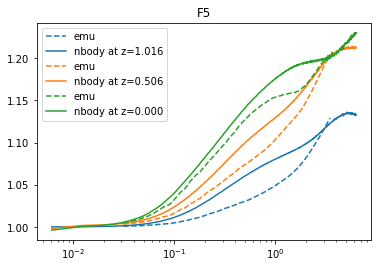

In [58]:
plt.figure(2)
for snap_id in snap_id_array:
    emu = MGemu(Om=Om_f, ns=ns_f, s8=s8_f, fR0=fr0_f5, n=n_f, z=z_array[snap_id])
    plt.plot(kvals, emu, '--', label='emu')
    plt.plot(nbody_pk[snap_id, :,0], nbody_pk[snap_id, :, 2], label='nbody at z=%0.3f'%z_array[snap_id], color=plt.gca().lines[-1].get_color())
plt.xscale('log')
plt.title('F5')
plt.legend()
plt.show()

./Models/Fixedn/nCorrLogfixedGP_smooth_rank16snap47
[ 0.13651233  0.971       0.82       -6.          1.        ]
[0.47178083 0.605      0.6        0.5        0.25      ]
./Models/Fixedn/nCorrLogfixedGP_smooth_rank16snap48
[ 0.13651233  0.971       0.82       -6.          1.        ]
[0.47178083 0.605      0.6        0.5        0.25      ]
Linear interpolating for snapshots  for z1= 47 and z2= 48
./Models/Fixedn/nCorrLogfixedGP_smooth_rank16snap64
[ 0.13651233  0.971       0.82       -6.          1.        ]
[0.47178083 0.605      0.6        0.5        0.25      ]
./Models/Fixedn/nCorrLogfixedGP_smooth_rank16snap65
[ 0.13651233  0.971       0.82       -6.          1.        ]
[0.47178083 0.605      0.6        0.5        0.25      ]
Linear interpolating for snapshots  for z1= 64 and z2= 65
./Models/Fixedn/nCorrLogfixedGP_smooth_rank16snap99
[ 0.13651233  0.971       0.82       -6.          1.        ]
[0.47178083 0.605      0.6        0.5        0.25      ]


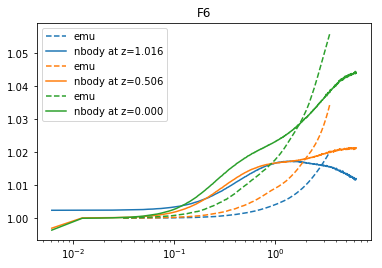

In [59]:
plt.figure(3)
for snap_id in snap_id_array:
    emu = MGemu(Om=Om_f, ns=ns_f, s8=s8_f, fR0=fr0_f6, n=n_f, z=z_array[snap_id])
    plt.plot(kvals, emu, '--', label='emu')
    plt.plot(nbody_pk[snap_id, :,0], nbody_pk[snap_id, :, 3], label='nbody at z=%0.3f'%z_array[snap_id], color=plt.gca().lines[-1].get_color())
plt.xscale('log')
plt.title('F6')
plt.legend()
plt.show()

In [ ]:
# # GPmodel, PCAmodel = modelLoad(nRankMax, 47)
# # print(Emu(GPmodel, PCAmodel, np.array([Om_f, ns_f, s8_f, fr0_f6, n_f])))

# def modelLoad102(nRankMax, snap_ID):
#     GPmodel = modelDir + '102GP_smooth_rank' + str(nRankMax) + 'snap' + str(snap_ID)  
#     PCAmodel = modelDir + '102PCA_smooth_rank' + str(nRankMax) + 'snap' + str(snap_ID)  

#     ctx_for_loading = gpflow.saver.SaverContext(autocompile=False)
#     saver = gpflow.saver.Saver()
#     GPm = saver.load(GPmodel, context=ctx_for_loading)
#     GPm.clear()
#     GPm.compile()
#     PCAm = pickle.load(open(PCAmodel, 'rb'))

#     print(GPmodel)
#     return GPm, PCAm

# GPmodel, PCAmodel = modelLoad102(nRankMax, 47)
# print(Emu(GPmodel, PCAmodel, np.array([Om_f, ns_f, s8_f, fr0_f6, n_f])))
# print([Om_f, ns_f, s8_f, fr0_f6, n_f])

./Models/Fixedn/nCorrLogfixedGP_smooth_rank16snap47
[ 0.137  0.971  0.82  -4.     1.   ]
[0.472 0.605 0.6   1.    0.25 ]
./Models/Fixedn/nCorrLogfixedGP_smooth_rank16snap48
[ 0.137  0.971  0.82  -4.     1.   ]
[0.472 0.605 0.6   1.    0.25 ]
Linear interpolating for snapshots  for z1= 47 and z2= 48
./Models/Fixedn/nCorrLogfixedGP_smooth_rank16snap69
[ 0.137  0.971  0.82  -4.     1.   ]
[0.472 0.605 0.6   1.    0.25 ]
./Models/Fixedn/nCorrLogfixedGP_smooth_rank16snap70
[ 0.137  0.971  0.82  -4.     1.   ]
[0.472 0.605 0.6   1.    0.25 ]
Linear interpolating for snapshots  for z1= 69 and z2= 70
./Models/Fixedn/nCorrLogfixedGP_smooth_rank16snap88
[ 0.137  0.971  0.82  -4.     1.   ]
[0.472 0.605 0.6   1.    0.25 ]
./Models/Fixedn/nCorrLogfixedGP_smooth_rank16snap89
[ 0.137  0.971  0.82  -4.     1.   ]
[0.472 0.605 0.6   1.    0.25 ]
Linear interpolating for snapshots  for z1= 88 and z2= 89
./Models/Fixedn/nCorrLogfixedGP_smooth_rank16snap99
[ 0.137  0.971  0.82  -4.     1.   ]
[0.472 0.60

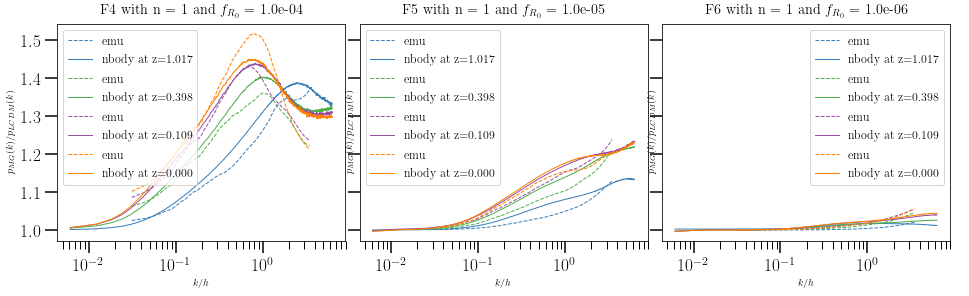

In [24]:
import SetPub
SetPub.set_pub()

fig, ax = plt.subplots(1, 3, figsize = (16,4), sharey=True)
plt.subplots_adjust(wspace=0.02)

color_id = 0
for snap_id in snap_id_array:
    color_id = color_id + 1

    emu = MGemu(Om=Om_f, ns=ns_f, s8=s8_f, fR0=fr0_f4, n=n_f, z=z_array[snap_id])
    ax[0].plot(kvals, emu, label='emu', ls='--', color=plt.cm.Set1(color_id) )
    ax[0].plot(nbody_pk[snap_id, :,0], nbody_pk[snap_id, :, 1], label='nbody at z=%0.3f'%z_array[snap_id],  color=plt.cm.Set1(color_id) )
    #color=plt.gca().lines[-1].get_color())

ax[0].set_xscale('log')
ax[0].set_title('F4 with n = 1 and ' + r'$f_{R_0}$ = %1.1e'%fr0_f4)
ax[0].legend()

color_id = 0
for snap_id in snap_id_array:
    color_id = color_id + 1

    emu = MGemu(Om=Om_f, ns=ns_f, s8=s8_f, fR0=fr0_f5, n=n_f, z=z_array[snap_id])
    ax[1].plot(kvals, emu, label='emu', ls='--', color=plt.cm.Set1(color_id) )
    ax[1].plot(nbody_pk[snap_id, :,0], nbody_pk[snap_id, :, 2], label='nbody at z=%0.3f'%z_array[snap_id], color=plt.cm.Set1(color_id) )

ax[1].set_xscale('log')
ax[1].set_title('F5 with n = 1 and ' + r'$f_{R_0}$ = %1.1e'%fr0_f5)
ax[1].legend()

color_id = 0
for snap_id in snap_id_array:
    color_id = color_id + 1 
    
    emu = MGemu(Om=Om_f, ns=ns_f, s8=s8_f, fR0=fr0_f6, n=n_f, z=z_array[snap_id])
    ax[2].plot(kvals, emu, label='emu' , ls='--', color=plt.cm.Set1(color_id) )
    ax[2].plot(nbody_pk[snap_id, :,0], nbody_pk[snap_id, :, 3], label='nbody at z=%0.3f'%z_array[snap_id], color=plt.cm.Set1(color_id) )

ax[2].set_xscale('log')
ax[2].set_title('F6 with n = 1 and ' + r'$f_{R_0}$ = %1.1e'%fr0_f6)
ax[2].legend()

plt.savefig('/Users/nramachandra/Desktop/Projects/Fr0/PyEmu/nbody_emu_fs.pdf', layout='tight' )

ax[0].set_ylabel(r'$p_{MG}(k)/p_{LCDM}(k)$')
ax[0].set_xlabel(r'$k/h$')
ax[1].set_ylabel(r'$p_{MG}(k)/p_{LCDM}(k)$')
ax[1].set_xlabel(r'$k/h$')
ax[2].set_ylabel(r'$p_{MG}(k)/p_{LCDM}(k)$')
ax[2].set_xlabel(r'$k/h$')

plt.show()




